<a href="https://colab.research.google.com/github/Pacifier25/ZTM-Tensorflow-course/blob/main/04_transfer_learning_in_tensorflow_feature_extractionipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is levaraging a working model's existing architecture and learned problem on our own pattern

There are two main benefits to using transfer learning:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

In [ ]:
# Are we using a GPU?
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Downloading and becoming one with the data

In [ ]:
# Get data (10% of labels)
import zipfile
# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip","r")
zip_ref.extractall()
zip_ref.close()


--2021-05-20 07:05:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.33.208, 172.217.13.80, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.33.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   112MB/s    in 1.4s    

2021-05-20 07:05:26 (112 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 10 directori

# Creating data loaders (preparing the data)

we will use the ImageDataGenreator class to load in our images in our batches


In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test"


train_datagen = ImageDataGenerator(1/255.)
test_datagen = ImageDataGenerator(1/255.)

print("Training images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                           target_size = IMAGE_SHAPE,
                                                           batch_size = BATCH_SIZE,
                                                           class_mode = "categorical")

print("Test images")
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size = IMAGE_SHAPE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = "categorical")

Training images
Found 750 images belonging to 10 classes.
Test images
Found 2500 images belonging to 10 classes.


# Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* **Experiment tracking with TensorBoard** - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* **Model checkpointing** - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* **Early stopping** - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime

def create_tensor_board_callbacks(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callbacks

# Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

we can access pretrained model on:https://tfhub.dev/



In [ ]:
# Let's compare the following two models

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/bit/m-r50x1/1"
#EfficientNet0 feature vector
efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers



In [ ]:
def create_model(model_url, num_classes=10):

  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
   # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable = False,# freeze the underlying patterns
                                             name = 'featured_extraction_layer',
                                             input_shape = (224,224,3))# define the input image shape

   # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer, # use the feature extraction layer as the base
      tf.keras.layers.Dense(num_classes,activation = tf.keras.activations.softmax,name = "output_model")
   ])                

  return model                        

In [ ]:
def create_model(model_url , num_classes = 10):
  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it
 
  Args: 
     model_url (str): A TensorFlow Hub feature extraction URL 
     num_classes (int): Number of output neuron in the output layer, should be 
                       equal to the number of target classes, default 10. 
 
  Returns: 
  An uncompiled Keras Sequential model with model_url as feature extractor layer 
  and Dense output layer with num_classes output neurons. 
  '''
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url , 
                                           trainable = False, # freeze the already learnt model 
                                           name = 'feature_extraction_layer' , 
                                           input_shape = IMG_SHAPE + (3,)) # (224, 224, 3)
 
  # Create our own model 
  model = tf.keras.Sequential([
    feature_extraction_layer , 
    layers.Dense(num_classes , activation=tf.keras.activations.softmax , name = 'output_layer')
  ])
  
  return model

# Creating and testing Resnet TensorFlow Hub feature Extraction Model

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
featured_extraction_layer (K (None, 2048)              23500352  
_________________________________________________________________
output_model (Dense)         (None, 10)                20490     
Total params: 23,520,842
Trainable params: 20,490
Non-trainable params: 23,500,352
_________________________________________________________________


In [ ]:
# Let's fit our Resnet model to the data(10 percent of 10 classes)
resnet_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])



In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensor_board_callbacks(dir_name = "tensorflow hub", # save experiment logs here
                                                                            experiment_name = "resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow hub/resnet50V2/20210520-070551


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
24/24 [==============================] - 669s 28s/step - loss: 3.7969 - accuracy: 0.2671 - val_loss: 0.7871 - val_accuracy: 0.7620
Epoch 2/5
24/24 [==============================] - 656s 28s/step - loss: 0.7066 - accuracy: 0.7981 - val_loss: 0.6238 - val_accuracy: 0.8324
Epoch 3/5
24/24 [==============================] - 659s 28s/step - loss: 0.3692 - accuracy: 0.8888 - val_loss: 0.4877 - val_accuracy: 0.8612
Epoch 4/5
24/24 [==============================] - 656s 28s/step - loss: 0.2395 - accuracy: 0.9225 - val_loss: 0.4656 - val_accuracy: 0.8624
Epoch 5/5
24/24 [==============================] - 652s 28s/step - loss: 0.1380 - accuracy: 0.9534 - val_loss: 0.4296 - val_accuracy: 0.8800


Wow!

It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...with only 10 percent of the training images!

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curve(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  # Plot loss
  plt.plot(epochs,loss,label = 'training_loss')
  plt.plot(epochs,val_loss,label = 'val_loss')
  plt.title('loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label ='training_accuracy')
  plt.plot(epochs,val_accuracy,label = 'val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

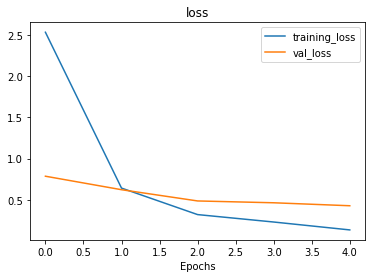

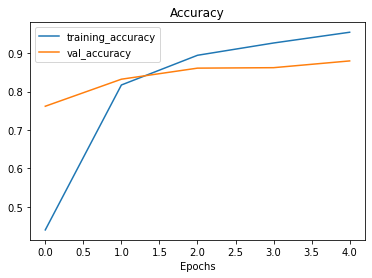

In [ ]:
plot_loss_curve(resnet_history)

# Creating and testing EffecientNetB0 TensorFlow hub featre extraction model

In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficient_url,
                                  num_classes = train_data_10_percent.num_classes)
# Compile EfficientNet model
efficientnet_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ["accuracy"])

efficient_history = efficientnet_model.fit(train_data_10_percent,
                    epochs = 5,
                    steps_per_epoch = len(train_data_10_percent),
                    validation_data = test_data,
                    validation_steps = len(test_data),
                    callbacks = [create_tensor_board_callbacks(dir_name="tensorflow_hub",
                                                               experiment_name = "efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210520-080054


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
24/24 [==============================] - 195s 8s/step - loss: 902.6947 - accuracy: 0.0820 - val_loss: 577.9097 - val_accuracy: 0.1132
Epoch 2/5
24/24 [==============================] - 184s 8s/step - loss: 474.1990 - accuracy: 0.1564 - val_loss: 537.0837 - val_accuracy: 0.1216
Epoch 3/5
24/24 [==============================] - 184s 8s/step - loss: 299.7393 - accuracy: 0.1708 - val_loss: 503.5878 - val_accuracy: 0.1128
Epoch 4/5
24/24 [==============================] - 183s 8s/step - loss: 239.1675 - accuracy: 0.1851 - val_loss: 501.8541 - val_accuracy: 0.1116
Epoch 5/5
24/24 [==============================] - 183s 8s/step - loss: 206.6151 - accuracy: 0.2603 - val_loss: 492.5180 - val_accuracy: 0.1144


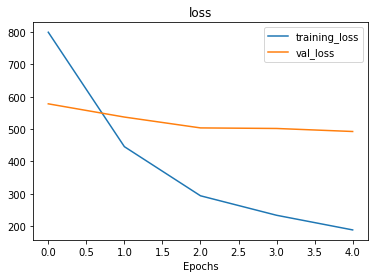

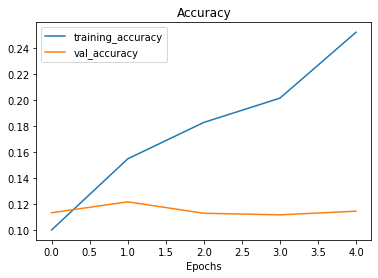

In [ ]:
plot_loss_curve(efficient_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
featured_extraction_layer (K (None, 1280)              4049564   
_________________________________________________________________
output_model (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


### Different type of machine learning:

* **As is" transfer learning**-using an existing model with no changes what so ever(eg. using ImageNet model on 1000 ImageNet classes,none of your own)

* **Feature extraction**-transfer learning -use the prelearned model pattern of an existing model (eg - EfficientNetB0 trained on ImageNet ) and adjust the  output layer of your own

* **Fine tuning**-trasfer learning- use the prelearned pattern of an existing model and fine tune many or  all of them the underlying layers(including new output)